# Artificial Bee Colony
The artificial bee colony (ABC) algorithm is another bio-inspired algorithm that replicates insect behaviour. In ABC, we use the following concepts:
- food source: a solution to the problem
- employed bee: a bee that is currently working, going to the food source, looking around, and coming back to the hive
- onlooker bee: a bee at the hive that observes incoming bees
- scout bee: generates new paths when old ones are abandoned

Essentially, employed bees are assigned an initial food source. They fly out of the hive to their assigned food source, and examine its surroundings. If there is a neighouring source better than the originally assigned source, the employed bee replaces the original with the better solution, and flies back to the hive. 
At the hive, the onlooker bees watch the dances of the incoming bees. These dances will vary depending on the amount of food (the cost of the solution), and the onlooker chooses a food source. These onlooker bees then swap places with the employed bees, and fly out of the hive to repeat the process. If a food source is abandoned, a new randomly generated food source found by the scout bees replaces it.

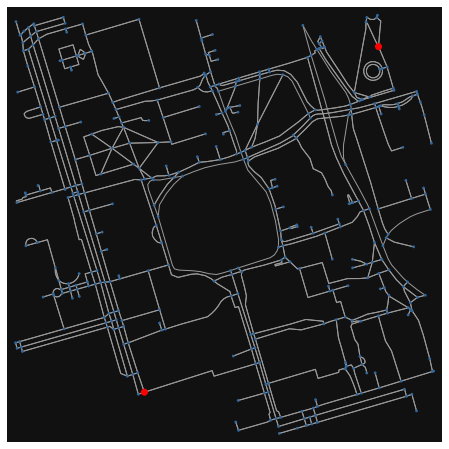

In [93]:
import osmnx
from smart_mobility_utilities.common import Node, cost, randomized_search
from smart_mobility_utilities.children import get_children
from smart_mobility_utilities.viz import draw_route
from tqdm.notebook import tqdm
import random
import matplotlib.pyplot as plt
import math

reference = (43.661667, -79.395)

G = osmnx.graph_from_point(reference, dist=300, clean_periphery=True, simplify=True)

origin = Node(graph=G, osmid=55808290)
destination = Node(graph=G, osmid=389677909)

highlighted = [389677909, 55808290]

# marking both the source and destination node

nc = ['red' if node in highlighted else '#336699' for node in G.nodes()]
ns = [50 if node in highlighted else 8 for node in G.nodes()]
fig, ax = osmnx.plot_graph(G, node_size=ns, node_color=nc, node_zorder=2)

In [94]:
# Initialize some parameters
max_iter = 200
total_bees = 10 # this must be an even number
food_sources = []
food_costs = []
onlooker_sources = []
onlooker_costs = []
states = []
best_cost = math.inf
best_path = None

# Initialize the food sources and assign to employed bees
# Bees' id is just the list index
food_sources = [randomized_search(G,origin.osmid, destination.osmid) for _ in range(total_bees//2)]
food_costs = [cost(G,route) for route in food_sources]
onlooker_sources = [[] for _ in food_sources]
onlooker_costs = [math.inf for _ in food_sources]

In [95]:
for _ in tqdm(range(max_iter)):
    for i in range(total_bees//2):
        # Each employed bee finds a neighbour to their solution
        neighbour = get_children(G,food_sources[i],1)[0]
        neighbour_cost = cost(G,neighbour)
        # If the neighbour is better forget the old one
        if neighbour_cost < food_costs[i]:
            food_sources[i] = neighbour
            food_costs[i] = neighbour_cost
        # Keep track of the best cost
        if neighbour_cost < best_cost:
            best_cost = neighbour_cost
            best_path = neighbour
    
    # Onlooker bees pick a food source probabilistically
    total = sum(1/x for x in food_costs)
    probs = [(1/food_costs[i])/total for i in range(total_bees//2)]

    onlooker_to_visit = []
    for i in range(total_bees//2):
        choice = random.choices(population=food_sources,weights=probs)[0]

        # If the onlooker's choice is not even as good as the current, 
        # just explore a neighbour of the current instead.
        if cost(G,choice) > onlooker_costs[i]:
            neighbour = get_children(G,onlooker_sources[i],1)[0]
            neighbour_cost = cost(G,neighbour)
            if neighbour_cost < onlooker_costs[i]:
                onlooker_sources[i] = neighbour
                onlooker_costs[i] = neighbour_cost
                if neighbour_cost < best_cost:
                    best_cost = neighbour_cost
                    best_path = neighbour
            continue
        
        # Otherwise, generate a neighbour of the solution the onlooker bee has selected
        # Since the employed solution is good, we'll keep it
        onlooker_to_visit.append(choice)

        onlooker_neighbour = get_children(G,choice,1)[0]
        onlooker_neighbour_cost = cost(G,onlooker_neighbour)
        if onlooker_neighbour_cost < best_cost:
            best_cost = onlooker_neighbour_cost
            best_path = onlooker_neighbour
        # If the neighbour of the employed solution is better, use that instead,
        # otherwise, keep the employed solution
        if onlooker_neighbour_cost < cost(G,choice):
            onlooker_sources[i] = onlooker_neighbour
            onlooker_costs[i] = onlooker_neighbour_cost
        else:
            onlooker_sources[i] = choice
            onlooker_costs[i] = cost(G,choice)
        

    scouts = []

    for i in range(total_bees//2):
        # Check to see which paths were abandoned
        if food_sources[i] in onlooker_to_visit: continue
        scouts.append(i)
    
    for i in scouts:
        food_sources[i] = randomized_search(G,origin.osmid,destination.osmid)
        food_costs[i] = cost(G,food_sources[i])   

    states.append(best_cost)

  0%|          | 0/200 [00:00<?, ?it/s]

In [96]:
print("Cost:",best_cost)
draw_route(G,best_path)

Cost: 801.718


Map(center=[43.6609405, -79.3951948], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_titl…

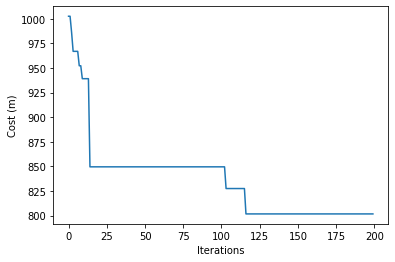

In [97]:
plt.plot(states)
plt.xlabel("Iterations")
plt.ylabel("Cost (m)")
plt.show()